In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
from torch.autograd import Variable
from train import Discr, GenDisco
import torchvision.transforms as transforms
from torchvision import datasets
from machinedesign.viz import grid_of_images_default, horiz_merge
from skimage.io import imsave
from IPython.display import Image

In [11]:
code_size = 128
ncols = 3
imageSize = 64
batchSize = 32

In [7]:
G = GenDisco(nz=ncols+code_size)
G.load_state_dict(torch.load('samples_3/netG_epoch_1013.pth'))

In [3]:
netE_G = Discr(nc=ncols, no=code_size, imagesize=imageSize)
netE_G.load_state_dict(torch.load('samples_3/netE_G_epoch_1013.pth'))

In [4]:
transform = transforms.Compose([
    transforms.Scale(imageSize),
    transforms.CenterCrop(imageSize),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [5]:
dataset = datasets.ImageFolder(
    '/home/mcherti/work/code/external/CycleGAN/datasets/apple2orange/trainA', 
    transform)
dataloader_A = torch.utils.data.DataLoader(
    dataset, 
    batch_size=batchSize, 
    shuffle=True, 
    num_workers=1)

dataset = datasets.ImageFolder(
    '/home/mcherti/work/code/external/CycleGAN/datasets/apple2orange/trainB', 
    transform)
dataloader_B = torch.utils.data.DataLoader(
    dataset, 
    batch_size=batchSize, 
    shuffle=True, 
    num_workers=1)

In [19]:
dt = iter(dataloader_B)
Y, _ = next(dt)
Y = Variable(Y)
E = netE_G(Y)

dt = iter(dataloader_A)
X, _ = next(dt)
X = Variable(X)

code_g = netE_G(Y)
code_g = code_g.repeat(1, 1, imageSize, imageSize)
code_g = code_g.mean(0).repeat(Y.size(0), 1, 1, 1)

X_and_code = torch.cat((X, code_g), 1)
Y_hat = G(X_and_code)

In [20]:
input_images = X.data.numpy()
output_images = Y.data.numpy()
output_images_hat = Y_hat.data.numpy()

/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


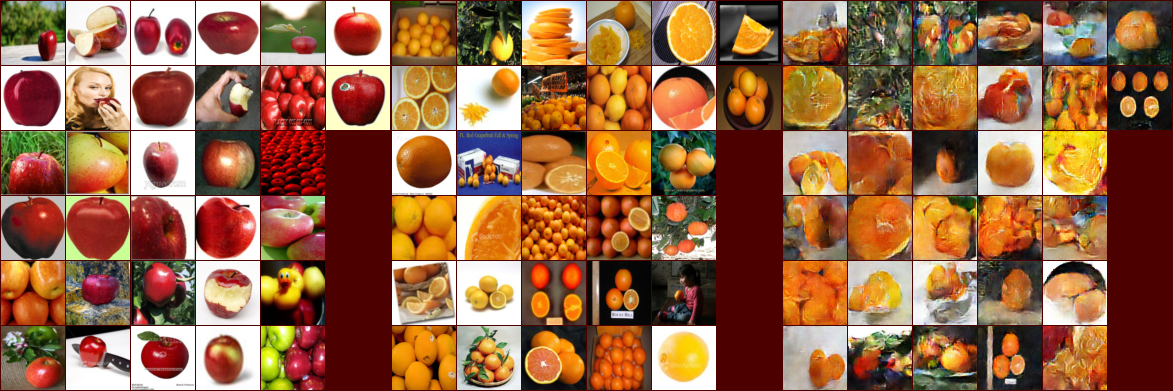

In [21]:
img = horiz_merge(
    grid_of_images_default(input_images, normalize=True), 
    horiz_merge(grid_of_images_default(output_images, normalize=True),
                grid_of_images_default(output_images_hat, normalize=True))
)
imsave('out.png', img)
Image('out.png')